## FX Hedging Case Study for Validus - Raghav Gumber

In [1]:
import scipy
import numpy as np
import pandas as pd
from hedge_class import hedge_pricer
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import math
import copy
import warnings
warnings.filterwarnings("ignore")
sns.set()

### Read in Data, set up pricer object

Refer to hedge_class.py for the library used for calculations

In [11]:
CF_DF=pd.read_excel("Data/Quantitative Analyst Case Study 2021 - Cashflow Model (1).xlsx",parse_dates=[0])
CF_DF.Date=[*map(lambda x: x.date(),CF_DF.Date)]
CF_DF['Cashflow Amount (in Local Asset Currecny)']

n_paths=1000
n_assets=1
r_drifts=[0]#[0,0]
sigma_vec=[.1]#[.1,.2]
spot=[1.3925]#[1.3925,1.3]
dt=1/252
total_time=5

CF={i:np.array([CF_DF['Cashflow Amount (in Local Asset Currecny)'][i]]) for i in range(total_time+1)}

corr=1
seed=0
hp=hedge_pricer(n_paths=n_paths,n_assets=n_assets,r_drifts=r_drifts,sigma_vec=sigma_vec,spot=spot,dt=dt,total_time=total_time,CF=CF,corr=corr,seed=seed)


### Part a

The model used here is:

$dS_t = r_{drift}*S_t*dt +\sigma*S_t*dW_t$ 

$W_t$ ~ $N(0,t)$ (Weiner Process)

$r_{drift}=r_{USD}-r_{GBP}=0,\sigma=.1$

$S_t=X_{\frac{GBP}{USD}}$=GBPUSD Spot

$dt=1/12 $(1 month)

Along every path, the equity path follows the lognormal distribution in the form of below:

$S_t=S_{t-1}*exp(r_{drift}-\frac{\sigma^2}{2})*dt+\sigma*z*dt^.5$

GBP is essentially an asset denoted in USD here. We show the 1000 paths of the GBPUSD spot below over 5 years.

Text(0.5,1,'GBPUSD Spot at every scenarios over Time')

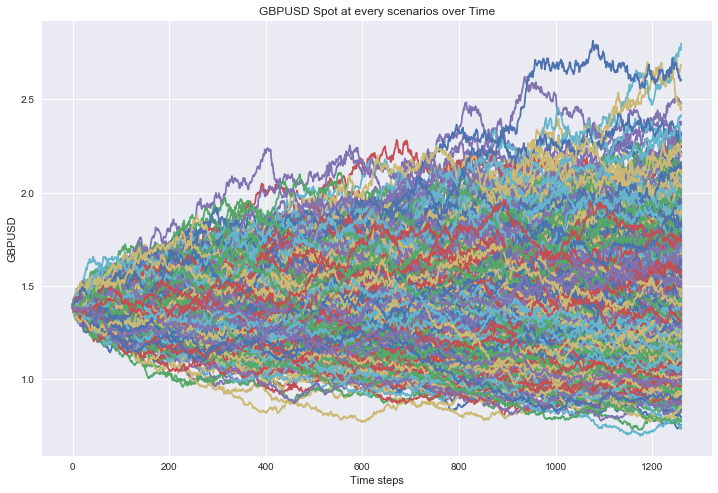

In [12]:
hp_paths=hp.ret_paths()
all_scen_paths_DF=pd.DataFrame(hp_paths.T[0])
ax=all_scen_paths_DF.iloc[::1].T.plot(figsize=(12,8),legend=None)
ax.set_xlabel("Time steps")
ax.set_ylabel("GBPUSD")
ax.set_title('GBPUSD Spot at every scenarios over Time')
#ax.set_xticklabels([0]+list(range(total_time+1)))

### Part b

For every scenario, we calculate the IRR to equate to 0 NPV of the CFs in the scenario. We show the IRRs distribution below along with key percentiles


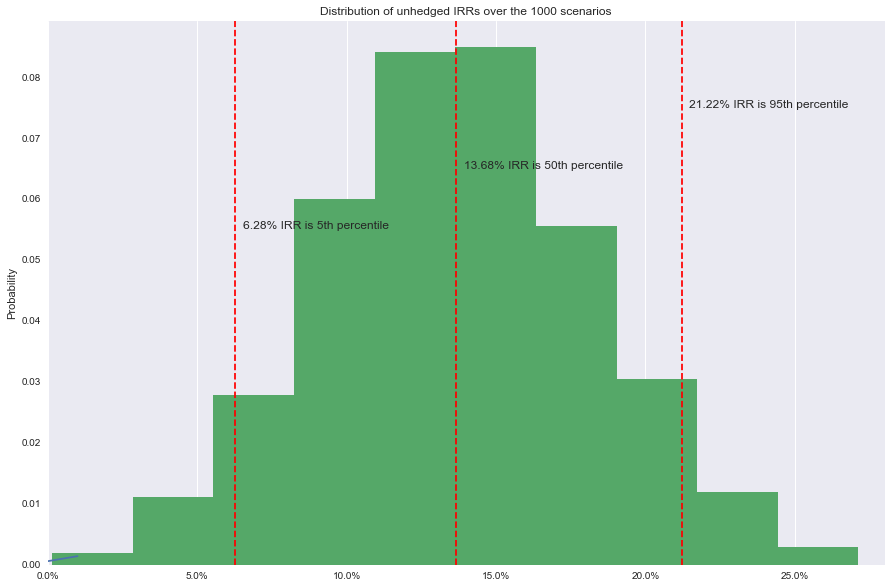

In [13]:
hp_CF_paths=hp.ret_CF(CF)
IRRs=[hp.solve_IRR(hp_CF_paths.T[0][i])*100 for i in range(n_paths)]

fig, ax = plt.subplots(1,1,figsize=(15,10))
hp.plot_IRRs(IRRs,ax)

### Part c

Since for every scenario we have the ending GBPUSD spot, we use that to value the option per every scenario as $N*max(K-X^T_{GBPUSD}),0)$ at every scenario. We ten discount every scenario's payoff by the forward rate, which here is 0 as $r_{USD}=r_{GBP}$

$Option PriceInUSD=\sum_{i=1}^{1000}{\frac{N*max(K-X^{T_i}_{GBPUSD},0)}{e^{r_{fwd}*T}}}=$ $12,413,675

$T =$ 5 Years = length of option, K=1.3925, i is $i^{th}$ scenario, N=100,000,000 GBP

$X^{T_i}_{GBPUSD}$ can be observed from the paths we generated in Part a)

In [5]:

r_usd=0
r_gbp=0
r_fwd=r_usd-r_gbp
K=1.3925
T=5
N=100000000
    
option_cost=hp.option_calc_put(r_fwd,K,T,N,index=0) ## Answer in USD
option_cost


12413675.00431352

### Part d
Upon adding the Cashflows observed by the option in every path to the CF path we generated in part b, we re-run the IRRs. We then plot them. We also plot tboth the densities on the same axis to get a clearer view

We primarily see a lognormal/heavy left-tail type distribution as opposed to a normal distribution as in part b. This makes sense as a large part of the cash recieved has been hedged essentially putting a floor on the IRR we would observe. Look at key observations below for more analysis:

| Metric | IRR unhedged |IRR hedged |Interpretation|
| --- | --- |--- |
| Mean | 13.43 |12.62 | Lower mean for unhedged to acount for cost of option|
| Std | 4.95 |2.94 | Makes sense as the hedge reduces variance|
| Skewness | .11 |1.04 | No surprise here, this is as hedged version definitely is not symmetric|
| Kurtosis | .02 |1.02 |  Hedged version has a heavy left tail as expected due to the potential upside of the optionality|

In [6]:
## Assuming cash is converted to USD right away


K=1.3925
T=5
dt=1/12
N=100000000
index=0
option_payoff_all_scen=[]
for i in range(len(hp_paths.T[index])):
    scen=hp_paths.T[index][i]
    option_payoff=[0]*(T)+[max((K-scen[math.ceil(T/dt)])*N,0)]
    option_payoff_disc=[math.exp(-r_fwd*i)*option_payoff[i] for i in range(T+1)]
    option_payoff[0]=-option_cost
    option_payoff_all_scen.append(option_payoff)
    
option_payoff_all_scen=np.array(option_payoff_all_scen)

hp_hedged_CF_paths=copy.deepcopy(hp_CF_paths)
hp_hedged_CF_paths.T[0]=(hp_hedged_CF_paths.T[0]+option_payoff_all_scen)


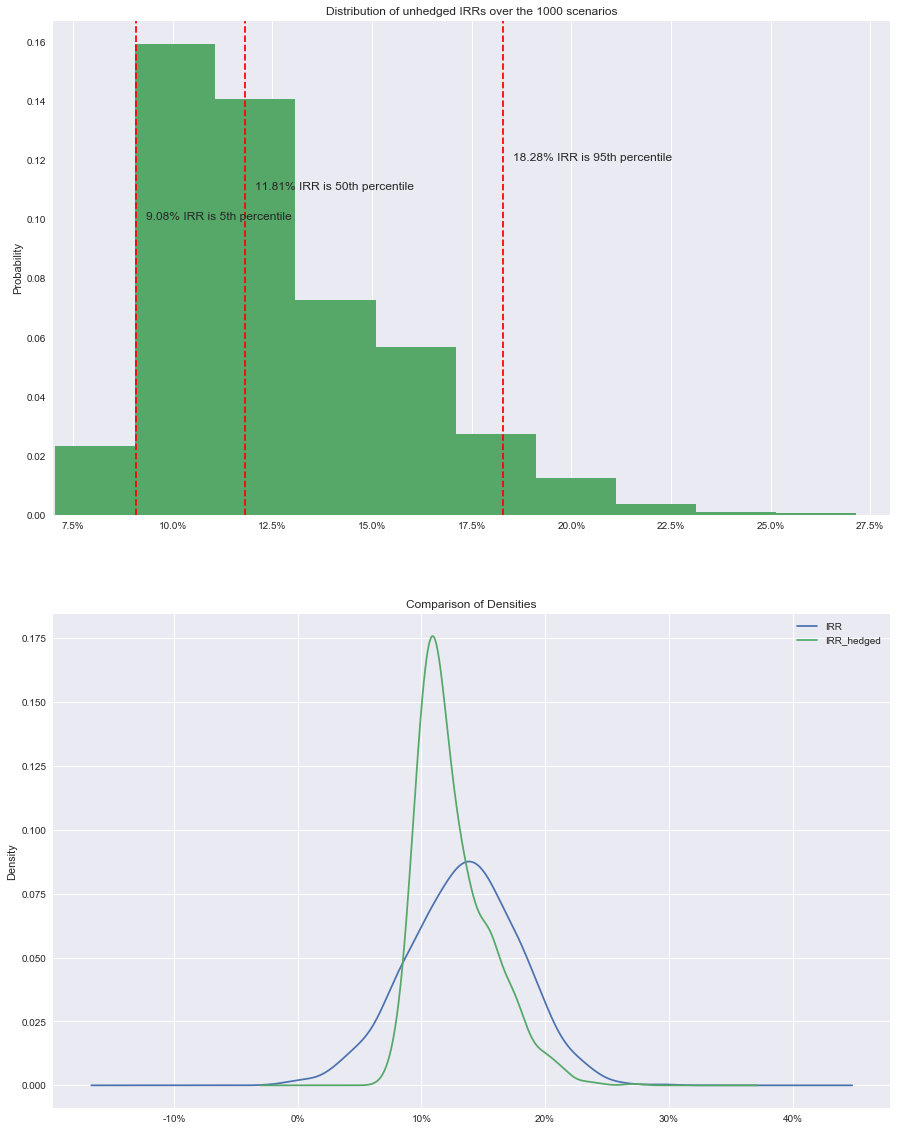

In [7]:
IRRs_hedged=[hp.solve_IRR(hp_hedged_CF_paths.T[0][i])*100 for i in range(n_paths)]

dist=pd.Series(IRRs_hedged)
fig, [ax,ax1] = plt.subplots(2,1,figsize=(15,20))


df=pd.DataFrame()
df['IRR']=IRRs
df['IRR_hedged']=IRRs_hedged
for s in df.columns:
    df[s].plot(kind='density',legend=True,ax=ax1)
ax1.xaxis.set_major_formatter(mtick.PercentFormatter())
ax1.set_title("Comparison of Densities")
hp.plot_IRRs(IRRs_hedged,ax=ax)

In [8]:

print("For IRR unhedged:Mean ={}. std ={}. skew={}. kurtosis={}".format(np.mean(IRRs),np.std(IRRs),scipy.stats.skew(IRRs),scipy.stats.kurtosis(IRRs)))
print("For IRR hedged:Mean ={}. std ={}. skew={}. kurtosis={}".format(np.mean(IRRs_hedged),np.std(IRRs_hedged),scipy.stats.skew(IRRs_hedged),scipy.stats.kurtosis(IRRs_hedged)))



For IRR unhedged:Mean =13.426210120608303. std =4.494992329477448. skew=-0.11203642544758337. kurtosis=0.023466838715335836
For IRR hedged:Mean =12.618441233275982. std =2.94365742773462. skew=1.0431737411013082. kurtosis=1.0233205043241584
